In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive
%mkdir -p 200821_tutorial/cnn_cifar
%cd 200821_tutorial/cnn_cifar
%pwd

/content/drive/My Drive
/content/drive/My Drive/200821_tutorial/cnn_cifar


'/content/drive/My Drive/200821_tutorial/cnn_cifar'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cpu


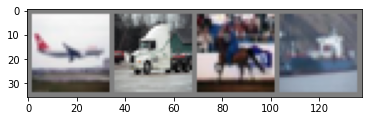

plane truck horse  ship


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.215
[1,  4000] loss: 1.872
[1,  6000] loss: 1.695
[1,  8000] loss: 1.590
[1, 10000] loss: 1.500
[1, 12000] loss: 1.474
[2,  2000] loss: 1.397
[2,  4000] loss: 1.367
[2,  6000] loss: 1.336
[2,  8000] loss: 1.319
[2, 10000] loss: 1.290
[2, 12000] loss: 1.278
Finished Training


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)